In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.decomposition import PCA
from scipy.spatial.distance import euclidean
from tqdm.notebook import trange
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

plt.style.use('fivethirtyeight')
%config InlineBackend.figure_formats = ['svg']

#### __Однофакторный диспресионный анализ__

Среди людей, проживающих в одном городе, выделены три группы по профессии: бухгалтеры, юристы, программисты. Имеются данные по зарплатам в этих трёх группах:

In [2]:
y1 = np.array([70, 50, 65, 60, 75])
y2 = np.array([80, 75, 90, 70, 75, 65, 85, 100])
y3 = np.array([130, 100, 140, 150, 160, 170, 200])

n1 = y1.shape[0]
n2 = y2.shape[0]
n3 = y3.shape[0]

n1, n2, n3

(5, 8, 7)

In [3]:
y1_mean = y1.mean()
y2_mean = y2.mean()
y3_mean = y3.mean()
y = np.concatenate([y1, y2, y3])
y_mean = y.mean()

y1_mean, y2_mean, y3_mean, y_mean

(64.0, 80.0, 150.0, 100.5)

In [4]:
SS_b = n1 * (y1_mean - y_mean) ** 2 + n2 * (y2_mean - y_mean) ** 2 + n3 * (y3_mean - y_mean) ** 2

SS_w = ((y1 - y1_mean) ** 2).sum() + ((y2 - y2_mean) ** 2).sum() + ((y3 - y3_mean) ** 2).sum()

SS_b, SS_w

(27175.0, 7270.0)

In [5]:
k = 3
n = n1 + n2 + n3

k1 = k - 1
k2 = n - k

sigma2_b = SS_b / k1
sigma2_w = SS_w / k2

F = sigma2_b / sigma2_w
F

31.77269601100413

In [6]:
alpha = 0.05

t = stats.f.ppf(1 - alpha, k1, k2)

t

3.5915305684750827

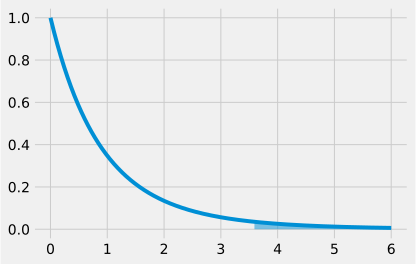

In [7]:
ox = np.linspace(0, 6, 500)
oy = stats.f.pdf(ox, k1, k2)

ox_right = np.linspace(t, 6, 100)
oy_right = stats.f.pdf(ox_right, k1, k2)

plt.plot(ox, oy)
plt.fill_between(ox_right, oy_right, alpha=0.5)

In [8]:
stats.f_oneway(y1, y2, y3)

F_onewayResult(statistic=31.77269601100413, pvalue=1.8091304567650962e-06)

#### __Метод главных компонент__

In [9]:
samples = np.array([[ 2.36499331, -0.57978654],
                    [ 5.70144948,  3.54257542],
                    [ 5.27028536,  2.1560189 ],
                    [ 4.14275078,  0.39188923],
                    [ 3.93109011,  0.87195848],
                    [ 4.59408573,  2.17496773],
                    [ 3.53666882,  0.84484304],
                    [ 5.13601245,  2.74557671],
                    [ 4.40989037,  1.7030094 ],
                    [ 5.05796456,  1.86949263]])

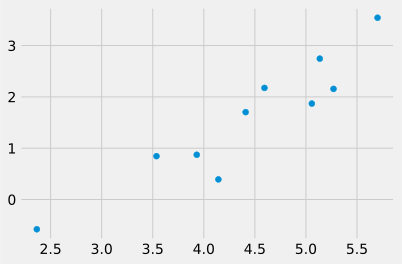

In [10]:
plt.scatter(samples[:, 0], samples[:, 1])

In [11]:
samples.mean(axis=0, keepdims=True)

array([[4.4145191, 1.5720545]])

__1) Центрируем матрицу__

In [12]:
samples_centered = samples - samples.mean(axis=0)
samples_centered

array([[-2.04952579, -2.15184104],
       [ 1.28693038,  1.97052092],
       [ 0.85576626,  0.5839644 ],
       [-0.27176832, -1.18016527],
       [-0.48342899, -0.70009602],
       [ 0.17956663,  0.60291323],
       [-0.87785028, -0.72721146],
       [ 0.72149335,  1.17352221],
       [-0.00462873,  0.1309549 ],
       [ 0.64344546,  0.29743813]])

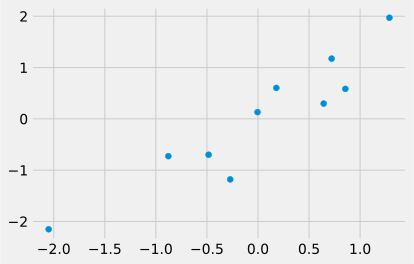

In [13]:
plt.scatter(samples_centered[:, 0], samples_centered[:, 1])

__2) Матрица ковариаций__

In [14]:
cov = np.cov(samples_centered.T, ddof=1)
cov

array([[0.95934497, 1.09880063],
       [1.09880063, 1.45693615]])

__3) Собственные векторы и собственные значения__

In [15]:
eigenvalues, eigenvectors = np.linalg.eig(cov)

ids = eigenvalues.argsort()[::-1]  # поскольку нам нужен порядок убывания

eigenvalues = eigenvalues[ids]
eigenvectors = eigenvectors[:, ids]

print(f'eigenvalues:\n{eigenvalues}\n')
print(f'eivenvectors:\n{eigenvectors}')

eigenvalues:
[2.33475587 0.08152525]

eivenvectors:
[[-0.62416562 -0.78129206]
 [-0.78129206  0.62416562]]


Проверим, что сумма собственных значений действительно равна $\sigma_X$:

In [16]:
sigma_x = samples.var(axis=0, ddof=1).sum()
sigma_x == eigenvalues.sum()

True

__4) Найти наименьший k__

Чтобы посмотреть, какую долю объяснённой дисперсии можно получить при каждом выборке $k$, воспользуемся функцией `numpy.cumsum`, которая считает кумулятивную сумму значений массива:
$$[a_1, a_1 + a_2, a_1 + a_2 + a_3, \dots]$$

In [17]:
(eigenvalues / sigma_x).cumsum()

array([0.96626003, 1.        ])

Видим, что если использовать только первую главную компоненту, удастся сохранить около $96 \%$ информации. Это очень неплохо.

Итак, нужно взять первый собственный вектор (столбец) и умножить на него центрированную матрицу $X^\ast$:

__5) Составим T из k векторов__

In [18]:
T = eigenvectors[:, [0]]
T

array([[-0.62416562],
       [-0.78129206]])

In [19]:
new_samples = samples_centered.dot(T)
new_samples

array([[ 2.96045985],
       [-2.34281004],
       [-0.99038663],
       [ 1.09168219],
       [ 0.84871921],
       [-0.58313064],
       [ 1.1160885 ],
       [-1.36719493],
       [-0.09942493],
       [-0.63400259]])

In [20]:
new_samples.var(ddof=1)

2.3347558703559046

__Готовая__

In [21]:
pca = PCA().fit(samples)
pca.components_.T

array([[-0.62416562,  0.78129206],
       [-0.78129206, -0.62416562]])

In [22]:
pca.explained_variance_ratio_

array([0.96626003, 0.03373997])

In [23]:
pca.transform(samples)[:, [0]]

array([[ 2.96045985],
       [-2.34281004],
       [-0.99038663],
       [ 1.09168219],
       [ 0.84871921],
       [-0.58313064],
       [ 1.1160885 ],
       [-1.36719493],
       [-0.09942493],
       [-0.63400259]])

#### __Логистическая регрессия__

In [24]:
def sigmoid(x: float) -> float:
    """Сигмоида.
    """
    
    return 1 / (1 + np.exp(-x))

In [25]:
def partial_derivative(j: int, b: np.ndarray, x: np.ndarray, y: np.ndarray) -> float:
    """Частная производная функционала Q по переменной b_j.
    """
    
    return sum(
        x[i, j] * (sigmoid(b.dot(x[i])) - y[i])
        for i in range(x.shape[0])
    )

In [26]:
def gradient(b: np.ndarray, x: np.ndarray, y: np.ndarray) -> np.ndarray:
    """Вектор градиента.
    """
    
    return np.array([
        partial_derivative(j, b, x, y)
        for j in range(b.shape[0])
    ])

In [27]:
def gradient_descent_step(
        lambda_: float,
        b: np.ndarray,
        x: np.ndarray,
        y: np.ndarray,
) -> np.ndarray:
    """Один шаг градиентного спуска.
    """
    
    return b - lambda_ * gradient(b, x, y)

[[ 2.36499331 -0.57978654]
 [ 5.70144948  3.54257542]
 [ 5.27028536  2.1560189 ]
 [ 4.14275078  0.39188923]
 [ 3.93109011  0.87195848]
 [ 4.59408573  2.17496773]
 [ 3.53666882  0.84484304]
 [ 5.13601245  2.74557671]
 [ 4.40989037  1.7030094 ]
 [ 5.05796456  1.86949263]]


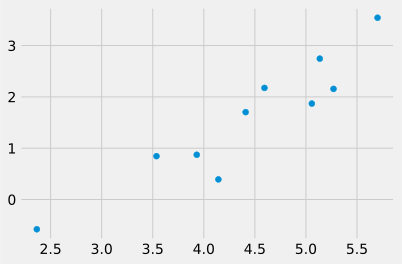

In [28]:
print(samples)

plt.scatter(samples[:, 0], samples[:, 1])

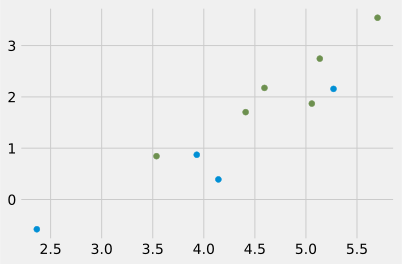

In [29]:
y = np.array([0, 1, 0, 0, 0, 1, 1, 1, 1, 1])

color = {0: 'C0', 1: 'C3'}
color = [color[i] for i in y]

plt.scatter(samples[:, 0], samples[:, 1], color=color)

In [30]:
samples = (samples - samples.min(axis=0)) / (samples.max(axis=0) - samples.min(axis=0))
samples

array([[0.        , 0.        ],
       [1.        , 1.        ],
       [0.87077183, 0.66364998],
       [0.53282806, 0.2357085 ],
       [0.46938929, 0.3521634 ],
       [0.66810181, 0.66824658],
       [0.35117366, 0.34558576],
       [0.83052766, 0.80666455],
       [0.61289493, 0.55375922],
       [0.80713521, 0.59414462]])

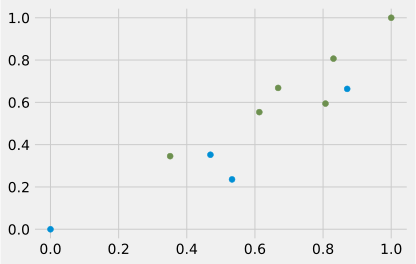

In [31]:
plt.scatter(samples[:, 0], samples[:, 1], color=color)

In [32]:
ones = np.ones((samples.shape[0], 1))
x = np.hstack([ones, samples])
x

array([[1.        , 0.        , 0.        ],
       [1.        , 1.        , 1.        ],
       [1.        , 0.87077183, 0.66364998],
       [1.        , 0.53282806, 0.2357085 ],
       [1.        , 0.46938929, 0.3521634 ],
       [1.        , 0.66810181, 0.66824658],
       [1.        , 0.35117366, 0.34558576],
       [1.        , 0.83052766, 0.80666455],
       [1.        , 0.61289493, 0.55375922],
       [1.        , 0.80713521, 0.59414462]])

Нам понадобится метрика чтобы вычислять расстояние между соседними векторами параметров. Будем использовать евклидово расстояние.

In [33]:
b_0 = np.zeros(x.shape[1])

b = b_0

for k in trange(1, 10 ** 6):
    lambda_ = 0.1 / k
    
    b_new = gradient_descent_step(lambda_, b, x, y)
        
    if euclidean(b, b_new) < 10 ** (-5):
        print(f'success on step {k}\n')
        
        break
    
    b = b_new

b = b_new

print(b)

  0%|          | 0/999999 [00:00<?, ?it/s]

success on step 6136

[-0.03670051  0.41548189  0.65301927]


__Готовая__

In [34]:
model = LogisticRegression(solver='liblinear', fit_intercept=False)

model.fit(x, y)
b_sklearn = model.coef_.flatten()

print(f'Коэффициенты: {b_sklearn}')
print(f'Число итераций: {model.n_iter_}')

Коэффициенты: [-0.09047654  0.35720772  0.61585617]
Число итераций: [3]


#### __Матрица ошибок__

In [35]:
z = sigmoid(x.dot(b))
z_ = (z > 0.5).astype(int)
z, z_, y

(array([0.4908259 , 0.73726484, 0.68102051, 0.58385091, 0.5958714 ,
        0.66312724, 0.58294627, 0.69743985, 0.64096654, 0.66521849]),
 array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([0, 1, 0, 0, 0, 1, 1, 1, 1, 1]))

In [36]:
TP = ((y == 1) & (z_ == 1)).sum()
FP = ((y == 0) & (z_ == 1)).sum()
FN = ((y == 1) & (z_ == 0)).sum()
TN = ((y == 0) & (z_ == 0)).sum()

TP, FP, FN, TN

(6, 3, 0, 1)

In [37]:
confusion_matrix(y, z_)

array([[1, 3],
       [0, 6]])

In [38]:
accuracy = (TP + TN) / (TP + FP + FN + TN)
accuracy

0.7

In [39]:
accuracy_score(y, z_)

0.7

In [40]:
precision = TP / (TP + FP)
recall = TP / (TP + FN)

precision, recall

(0.6666666666666666, 1.0)

In [41]:
precision_score(y, z_), recall_score(y, z_)

(0.6666666666666666, 1.0)

In [42]:
z_sklearn = model.predict(x)
z_sklearn

array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [43]:
accuracy_score(y, z_sklearn), recall_score(y, z_sklearn), precision_score(y, z_sklearn)

(0.7, 1.0, 0.6666666666666666)

### __Задача 1__
Используя данные о хоккеистах (скачать можно здесь), проверьте, является ли среди хоккеистов из Финляндии, Норвегии и Дании значимым отличие: а) роста, б) BMI.

$H_0$ : незначимые отличия роста/BMI `Y1 = Y2 = Y3`

$H_1$ : значимые отличия роста/BMI `Y1 != Y2 != Y3`

In [44]:
df = pd.read_csv('data/hockey_players.csv', encoding='ISO-8859-1')
df.head()

,year,country,no,name,position,side,height,weight,birth,club,age,cohort,bmi
0,2001,RUS,10,tverdovsky oleg,D,L,185,84.0,1976-05-18,anaheim mighty ducks,24.952772,1976,24.543462
1,2001,RUS,2,vichnevsky vitali,D,L,188,86.0,1980-03-18,anaheim mighty ducks,21.119781,1980,24.332277
2,2001,RUS,26,petrochinin evgeni,D,L,182,95.0,1976-02-07,severstal cherepovetal,25.229295,1976,28.680111
3,2001,RUS,28,zhdan alexander,D,R,178,85.0,1971-08-28,ak bars kazan,29.675565,1971,26.827421
4,2001,RUS,32,orekhovsky oleg,D,R,175,88.0,1977-11-03,dynamo moscow,23.490760,1977,28.734694


In [45]:
df.drop_duplicates(['name'], inplace=True)

In [46]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
year,3278.0,2006.854790,4.453088,2001.000000,2004.000000,2006.000000,2010.000000,2016.000000
no,3278.0,28.527456,22.790116,1.000000,12.000000,23.000000,37.000000,98.000000
height,3278.0,183.825198,5.470169,165.000000,180.000000,184.000000,188.000000,205.000000
weight,3278.0,87.465680,7.046456,65.000000,83.000000,87.000000,92.000000,117.000000
age,3278.0,26.378294,4.254385,17.642710,23.240246,25.878166,29.151951,41.505818
cohort,3278.0,1980.360586,6.807564,1963.000000,1975.000000,1980.000000,1985.000000,1998.000000
bmi,3278.0,25.866793,1.499555,19.460881,24.915316,25.826446,26.861207,30.930438


In [47]:
df['country'].unique()

array(['RUS', 'AUT', 'BLR', 'CAN', 'CZE', 'FIN', 'GER', 'ITA', 'JPN',
       'LAT', 'NOR', 'SUI', 'SVK', 'SWE', 'UKR', 'USA', 'POL', 'SLO',
       'DEN', 'FRA', 'KAZ', 'HUN'], dtype=object)

In [48]:
y1_height = df.loc[(df['country'] == 'FIN'), 'height']
y2_height = df.loc[(df['country'] == 'NOR'), 'height']
y3_height = df.loc[(df['country'] == 'DEN'), 'height']

y1_bmi = df.loc[(df['country'] == 'FIN'), 'bmi']
y2_bmi = df.loc[(df['country'] == 'NOR'), 'bmi']
y3_bmi = df.loc[(df['country'] == 'DEN'), 'bmi']

In [49]:
stats.f_oneway(y1_height, y2_height, y3_height)

F_onewayResult(statistic=3.5504111023205005, pvalue=0.029563539043363198)

In [50]:
stats.f_oneway(y1_bmi, y2_bmi, y3_bmi)

F_onewayResult(statistic=8.473425512100832, pvalue=0.0002461427935245902)

Рост: P < F, значит отвергаем нулевую гипотезу, следовательно отличие роста между выборками спортсменов из Финляндии, Норвегии и Дании признается значимой

BMI:P < F, значит отвергаем нулевую гипотезу, следовательно отличие BMI между выборками спортсменов из Финляндии, Норвегии и Дании признается также значимой